<a href="https://colab.research.google.com/github/intel-analytics/analytics-zoo/blob/master/python/orca/colab-notebook/quickstart/tf2_keras_lenet_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


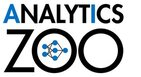
---

##### Copyright 2018 Analytics Zoo Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

## **Environment Preparation**

**Install Java 8**

Run the cell on the **Google Colab** to install jdk 1.8.

**Note:** if you run this notebook on your computer, root permission is required when running the cell to install Java 8. (You may ignore this cell if Java 8 has already been set up in your computer).


In [ ]:
# Install jdk8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
# Set environment variable JAVA_HOME.
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

**Install Analytics Zoo**

You can install the latest pre-release version using `pip install --pre --upgrade bigdl-orca`. 

In [ ]:
# Install latest pre-release version of Analytics Zoo 
# Installing Analytics Zoo from pip will automatically install pyspark, bigdl, and their dependencies.
!pip install --pre --upgrade bigdl-orca[ray]

## **Distributed TensorFlow 2 using Orca APIs**

In this guide we will describe how to scale out TensorFlow 2 programs using Orca in 4 simple steps.

In [ ]:
# import necesary libraries and modules
import argparse

from bigdl.orca import init_orca_context, stop_orca_context
from bigdl.orca import OrcaContext

### **Step 1: Init Orca Context** 

In [ ]:
# recommended to set it to True when running Analytics Zoo in Jupyter notebook 
OrcaContext.log_output = True # (this will display terminal's stdout and stderr in the Jupyter notebook).

cluster_mode = "local"

if cluster_mode == "local":  
    init_orca_context(cluster_mode="local", cores=1) # run in local mode
elif cluster_mode == "k8s":  
    init_orca_context(cluster_mode="k8s", num_nodes=2, cores=2) # run on K8s cluster
elif cluster_mode == "yarn":  
    init_orca_context(cluster_mode="yarn-client", num_nodes=2, cores=2) # run on Hadoop YARN cluster

This is the only place where you need to specify local or distributed mode. View [Orca Context](https://analytics-zoo.readthedocs.io/en/latest/doc/Orca/Overview/orca-context.html) for more details.

**Note**: You should export HADOOP_CONF_DIR=/path/to/hadoop/conf/dir when you run on Hadoop YARN cluster.

### **Step 2: Define the Model**

You can then define the Keras model in the *Creator Function* using the standard TensroFlow 2 APIs.

In [ ]:
def model_creator(config):
    import tensorflow as tf
    model = tf.keras.Sequential(
        [tf.keras.layers.Conv2D(20, kernel_size=(5, 5), strides=(1, 1), activation='tanh',
                                input_shape=(28, 28, 1), padding='valid'),
         tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
         tf.keras.layers.Conv2D(50, kernel_size=(5, 5), strides=(1, 1), activation='tanh',
                                padding='valid'),
         tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
         tf.keras.layers.Flatten(),
         tf.keras.layers.Dense(500, activation='tanh'),
         tf.keras.layers.Dense(10, activation='softmax'),
         ]
    )

    model.compile(optimizer=tf.keras.optimizers.RMSprop(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

### **Step 3: Define Train Dataset**

You can define the dataset in the _Creator Function_ using standard [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) APIs. 

In [ ]:
def preprocess(x, y):
    import tensorflow as tf
    x = tf.cast(tf.reshape(x, (28, 28, 1)), dtype=tf.float32) / 255.0
    return x, y

def train_data_creator(config, batch_size):
    import tensorflow as tf
    (train_feature, train_label), _ = tf.keras.datasets.mnist.load_data()

    dataset = tf.data.Dataset.from_tensor_slices((train_feature, train_label))
    dataset = dataset.repeat()
    dataset = dataset.map(preprocess)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(batch_size)
    return dataset

def val_data_creator(config, batch_size):
    import tensorflow as tf
    _, (val_feature, val_label) = tf.keras.datasets.mnist.load_data()

    dataset = tf.data.Dataset.from_tensor_slices((val_feature, val_label))
    dataset = dataset.repeat()
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch_size)
    return dataset

### **Step 4: Fit with Orca Estimator**

First, create an Estimator.



In [ ]:
from bigdl.orca.learn.tf2 import Estimator

batch_size = 320
est = Estimator.from_keras(model_creator=model_creator, workers_per_node=1)

Next, fit the Estimator.

In [ ]:
max_epoch=1
stats = est.fit(train_data_creator,
                epochs=max_epoch,
                batch_size=batch_size,
                steps_per_epoch=60000 // batch_size,
                validation_data=val_data_creator,
                validation_steps=10000 // batch_size)
est.save("/tmp/mnist_keras.ckpt")

Finally, evaluate using the Estimator.

In [ ]:
stats = est.evaluate(val_data_creator, num_steps=10000 // batch_size)
est.shutdown()
print(stats)

Now, the accuracy of this model has reached 98%.

In [ ]:
# Stop orca context when your program finishes
stop_orca_context()